# Pokemon GAN Training Notebook

**Import libraries**

In [10]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from dataset import PokemonGensDataset
from WGAN import WGAN
from utils import show_tensor_images
import variable as var
import os

**Load labels**

In [23]:
resume_training = True
train_number = 9
gan_id = f"wgan_pokemon_train_{train_number}"

greyscale = False
resize_image_dim = 64
n_conv_block = 3
batch_size = 128
print(f"Greyscale: {greyscale}")
print(f"Real: {resize_image_dim}x{resize_image_dim} images")
print(f"Fake: {2**(3 + n_conv_block)}x{2**(3 + n_conv_block)} images")

Greyscale: False
Real: 64x64 images
Fake: 64x64 images


In [24]:
dset = PokemonGensDataset(greyscale, resize=[resize_image_dim, resize_image_dim], gens_to_remove=("gen8", ))
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=0)

dloader = DataLoader(
    MNIST(os.environ['DATASETS'], 
          download=False, 
          transform=transforms.Compose([transforms.ToTensor(), 
                                        transforms.Resize([resize_image_dim, resize_image_dim])
                                       ])
         ), 
    batch_size=batch_size,
    shuffle=True)

In [25]:
len(dloader)*batch_size

6656

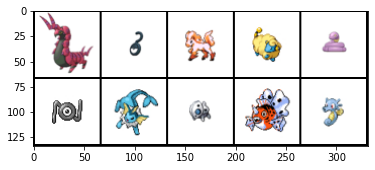

tensor([ 3, 10,  1,  6,  5, 10,  2, 16,  2,  2,  0, 13,  7, 14,  8,  7, 10,  0,
         1, 10,  3, 11, 16, 13, 10, 10,  4, 13,  9,  2,  0, 10, 16, 14, 14,  2,
         0,  2, 10,  0,  2, 15, 12, 11,  7, 11,  2, 10,  3,  0,  5,  7,  4,  3,
        11, 13,  5,  4,  2, 12, 10,  5,  2,  4,  5,  2,  2,  4,  2,  5, 16,  7,
         4, 10,  5, 11,  9,  5,  4,  2, 12,  6, 13,  1,  2,  1, 10,  5,  3,  0,
         1,  4,  0,  3,  2,  4, 14,  4,  3,  0,  0,  4,  8,  9,  4,  2,  3,  4,
         2,  4, 10,  3,  7,  2, 13,  4, 13,  2,  5,  2, 12, 13,  9,  4,  2,  3,
         4,  2])

In [26]:
images, labels = next(iter(dloader))
show_tensor_images(images)
labels

**GAN Component**

In [27]:
betas = (.5, .999)
n_channel = 1 if greyscale else 3
n_feature = 90
z_dim = 100
n_classes = len(dset.label_map)
    
params = {'gen': {'n_feature': n_feature,
                  'n_channel': n_channel,
                  'lr': 1e-4,
                  'betas': betas},
          'critic': {'n_channel': n_channel,
                   'n_feature': n_feature,
                   'lr': 1e-4,
                   'betas': betas},
          'z_dim': z_dim,
          'n_conv_block': n_conv_block,
          'gradient_penalty_factor': 10,
          'stability_noise_std': 5e-2
         }

In [28]:
gan = WGAN(params)
if os.path.exists(f'data/models/{gan_id}.pth'):
    print('RESUMING TRAINING...')
    gan.load_model(f'data/models/{gan_id}.pth')
else:
    print('NEW TRAINING...')
print(f'id: {gan_id}')

NEW TRAINING...
id: wgan_pokemon_train_9


In [29]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [30]:
gan.train(n_epoch=100, dataloader=dloader, gan_id=gan_id)

100%|██████████| 100/100 [35:47<00:00, 21.47s/it]


**RESULT**

In [38]:
str(dset.label_map)

"{0: 'grass', 1: 'fire', 2: 'water', 3: 'bug', 4: 'normal', 5: 'poison', 6: 'electric', 7: 'ground', 8: 'fairy', 9: 'fighting', 10: 'psychic', 11: 'rock', 12: 'ghost', 13: 'ice', 14: 'dragon', 15: 'dark', 16: 'steel', 17: 'flying'}"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class: fire


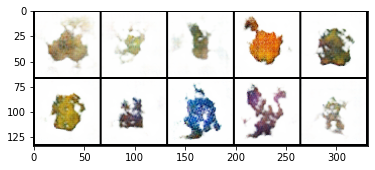

In [73]:
being_class = 1
print(f"class: {dset.label_map[being_class]}")
fakes, classes = gan.generate_fake(10, train=False, being_class=None)


show_tensor_images(fakes)

In [128]:
for i_batch, (real, real_classes) in enumerate(dloader):
    real = real.to(var.device)
    real_classes = real_classes.to(var.device)
    with torch.no_grad():
        _, real_aux = gan.discriminator(real)
    labels = torch.argmax(real_aux, dim=1)
    print((labels == real_classes).sum()/len(real_classes))

tensor(0.9844, device='cuda:0')
tensor(0.9922, device='cuda:0')
tensor(0.9766, device='cuda:0')
tensor(0.9844, device='cuda:0')
tensor(0.9844, device='cuda:0')
tensor(0.9844, device='cuda:0')
tensor(0.9394, device='cuda:0')


In [103]:
_, real_aux = gan.discriminator(images.to(var.device))

In [112]:
labels

tensor([10, 10,  4,  7,  0, 11, 10,  6, 10, 13,  6,  3, 14, 13,  6,  4,  6,  2,
         6, 13,  4, 14,  2,  3, 10,  2, 11,  0,  2,  0,  0, 16,  4, 10,  2,  4,
         1,  9,  7,  1,  0,  4,  4,  5,  2, 13,  2,  1,  2, 10, 16,  2,  4, 15,
         3,  2,  4,  0, 14,  4, 10,  7,  1,  3,  3,  7, 11,  5,  3, 16,  3,  3,
        14,  3,  4,  2,  3,  1,  7,  6,  0,  2,  5,  3,  6,  3,  2,  4,  0,  5,
         0,  5,  3,  2, 10, 13, 11,  9, 16, 14,  2,  5,  0,  1,  4,  3, 16, 10,
        10,  5,  1,  6,  3, 14, 14,  0, 10,  6, 10, 15,  0, 10,  2,  4, 14,  2,
         7,  4])

In [15]:
(torch.ones((4, )).long() * 5).dtype

torch.int64

In [57]:
torch.randn(3) * 0.1

tensor([-0.2394, -0.1888,  0.2054])

In [122]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.9) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

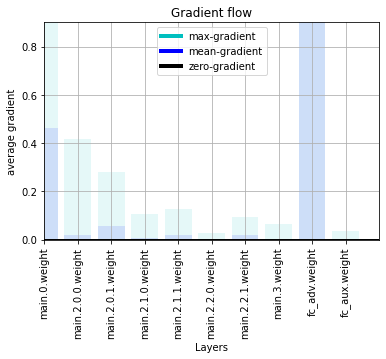

In [123]:
plot_grad_flow(gan.discriminator.named_parameters())

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D